In [1]:
import copy
import numpy as np

import torch
import torch.nn.functional as F
import torch.backends.cuda as cuda
from torch.utils.data import DataLoader, IterableDataset

from tqdm import tqdm
import bitsandbytes as bnb

from transformers import AutoTokenizer, GPTNeoXForCausalLM, TrainingArguments, Trainer, logging
from transformers.models.gpt_neox.modeling_gpt_neox import GPTNeoXAttention

name = "EleutherAI/pythia-410m"
tokenizer = AutoTokenizer.from_pretrained(name)

'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /EleutherAI/pythia-410m/resolve/main/tokenizer_config.json (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x7fb48284a9b0>, 'Connection to proxy-p.obspm.fr timed out. (connect timeout=10)'))"), '(Request ID: c8a2f7c5-18ab-495b-bccc-f9cee0f50778)')' thrown while requesting HEAD https://huggingface.co/EleutherAI/pythia-410m/resolve/main/tokenizer_config.json


### Train

In [2]:
import warnings 
warnings.filterwarnings("ignore")

In [3]:
from pynvml import *

def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")

In [4]:
def _attn_wrapper(self, query, key, value, attention_mask=None, head_mask=None):
    assert attention_mask is None and head_mask is None, "Not implemented"
    with cuda.sdp_kernel(enable_math=False):
        out = F.scaled_dot_product_attention(
            query.half(),
            key.half(),
            value.half(),
            is_causal=True,
        ).float()
    return out, None

# patch attention to save a lot of memory
GPTNeoXAttention._attn = _attn_wrapper

In [5]:
tokens = torch.load("../dataset/textbooks/textbooks.pt")
model = GPTNeoXForCausalLM.from_pretrained(name).cuda()

'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /EleutherAI/pythia-410m/resolve/main/config.json (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x7f344aeacc40>, 'Connection to proxy-p.obspm.fr timed out. (connect timeout=10)'))"), '(Request ID: 528f1354-8ecd-4691-8b44-05d21de8541b)')' thrown while requesting HEAD https://huggingface.co/EleutherAI/pythia-410m/resolve/main/config.json
'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /EleutherAI/pythia-410m/resolve/main/config.json (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x7f344aeaca30>, 'Connection to proxy-p.obspm.fr timed out. (connect timeout=10)'))"), '(Request ID: 8c51e119-6350-4f4f-8092-ee5e72b64d65)')' thrown while requesting HEAD https://huggingface.co/EleutherAI/pythia-410m/resolve/main/config.json
'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', 

In [6]:
class TokenDataset(IterableDataset):
    def __init__(self, tokens, block_size):
        self.tokens = tokens
        self.block_size = block_size
        
    def __iter__(self):
        for _ in range(int(1.5 * len(self.tokens) / self.block_size)):
            i = np.random.randint(len(self.tokens) - self.block_size)
            yield self.tokens[i: i + self.block_size]

In [7]:
class Trainer():
    def __init__(self, model, tokens):
        self.block_size = 2048
        self.grad = 16
        self.step = 0
        
        self.dataset = TokenDataset(tokens, self.block_size)
        self.loader = DataLoader(self.dataset, batch_size=4)
        
        self.scaler = torch.cuda.amp.GradScaler()
        self.opt = bnb.optim.Lion(
            params=model.parameters(),
            lr=1e-5,
            weight_decay=1e-1,
            betas=(0.9, 0.95),
            optim_bits=8,
        )
        self.model = torch.compile(model)
        
        self.loss = []

    def train_step(self, batch):
        batch = batch.cuda()
        x, y = batch[:, :-1], batch[:, 1:]
        with torch.autocast(device_type="cuda", enabled=True):
            z = self.model(x).logits
            y = y.reshape(-1)
            z = z.view(-1, z.shape[-1])
            loss = F.cross_entropy(z, y)
        self.scaler.scale(loss / self.grad).backward()
        return loss
    
    def train(self):
        prog = tqdm(self.loader)
        self.opt.zero_grad()

        for i, batch in enumerate(prog):
            self.step = i + 1

            loss = self.train_step(batch)
            prog.set_description(f"loss: {loss.item():.3f}")
            self.loss.append(loss.item())
            print_gpu_utilization()

            if (i + 1) % self.grad == 0:
                self.scaler.step(self.opt)
                self.scaler.update()
                self.opt.zero_grad()

            if i % 1000 == 0:
                temp_model = copy.deepcopy(self.model).half()
                temp_model.save_pretrained("trained-textbooks", from_pt=True)

                del temp_model
                torch.cuda.empty_cache()        

In [ ]:
trainer = Trainer(model, tokens)
trainer.train()

In [15]:
temp_model = copy.deepcopy(trainer.model).half()
temp_model.save_pretrained("trained-textbooks", from_pt=True)

del temp_model
torch.cuda.empty_cache()   

In [19]:
import pickle 

pickle.dump(trainer.loss, open('losses/loss-textbooks.pickle', 'wb'))

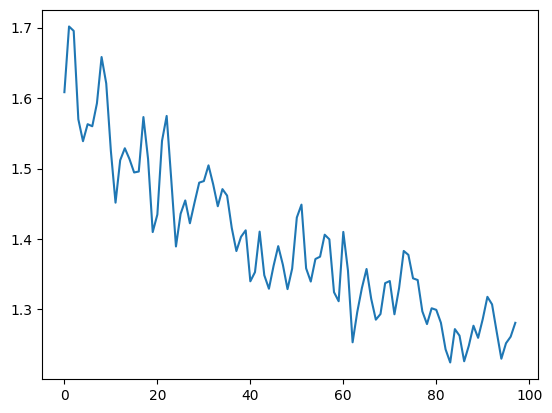

In [20]:
import matplotlib.pyplot as plt

plt.plot([np.mean(trainer.loss[i: i+100]) for i in range(0, len(trainer.loss), 50)])

### Inference

In [ ]:
model = GPTNeoXForCausalLM.from_pretrained("trained-textbooks").cuda()

In [4]:
prompt = "## Question:\n How do I prove\n Theorem plus_n_Sm : forall n m : nat, S (n + m) = n + (S m)."
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
outputs = model.generate(
    **inputs, max_new_tokens=300
)
result = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
result

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


'## Question:\n How do I prove\n Theorem plus_n_Sm : forall n m : nat, S (n + m) = n + (S m).\n\nI tried to prove it with induction, but I got stuck.\nTheorem plus_n_Sm : forall n m : nat, S (n + m) = n + (S m).\nProof.\nintros n m.\ninduction n.\n- intros.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  simpl.\n  '